In [36]:
period=-4800
time_interval='1d'
tickers = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X']
forex_tickers = ['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY']

%run forex_data_loader.ipynb

yfinance version: 0.2.47
Start load FOREX data interval with: 1d, from: 2011-10-10 20:42:48.672747


[*********************100%***********************]  4 of 4 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3427 entries, 2011-10-10 00:00:00+00:00 to 2024-11-30 00:00:00+00:00
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (EURUSD=X, Adj Close)  3425 non-null   float64
 1   (GBPUSD=X, Adj Close)  3426 non-null   float64
 2   (USDCHF=X, Adj Close)  3423 non-null   float64
 3   (USDJPY=X, Adj Close)  3427 non-null   float64
 4   (EURUSD=X, Close)      3425 non-null   float64
 5   (GBPUSD=X, Close)      3426 non-null   float64
 6   (USDCHF=X, Close)      3423 non-null   float64
 7   (USDJPY=X, Close)      3427 non-null   float64
 8   (EURUSD=X, High)       3425 non-null   float64
 9   (GBPUSD=X, High)       3426 non-null   float64
 10  (USDCHF=X, High)       3423 non-null   float64
 11  (USDJPY=X, High)       3427 non-null   float64
 12  (EURUSD=X, Low)        3425 non-null   float64
 13  (GBPUSD=X, Low)        3426 non-null   float64
 14  (USDCHF=

In [37]:
import os
import pandas as pd
import talib as ta
from talib import MA_Type
import warnings
from tqdm import tqdm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import backtesting
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

### Usefull functions

In [38]:
%run file_loader.ipynb
%run useful_functions.ipynb

### Loading data and Calculate Bollinger Bands and RSI and apply Signal

In [39]:
dir = "forex_data"
forex_dict = {}
for name in forex_tickers:
    f = os.path.join(dir, name+'.csv')
    if os.path.isfile(f):
        df = loading_v3(f)
        df = df[df.High != df.Low]
        df['bb_up'], df['bb_mid'], df['bb_low'] = ta.BBANDS(df["Close"], timeperiod=30, matype=MA_Type.EMA)
        df['bb_width'] = (df['bb_up'] - df['bb_low']) / df['bb_mid']
        df['rsi'] = ta.RSI(df['Close'], timeperiod=14)
        df["atr"] = ta.ATR(low = df['Low'], close = df['Close'], high = df['High'], timeperiod=14)

        add_bb_rsi_signal(df=df, rsi_threshold_low=30, rsi_threshold_high=70, bb_width_threshold=0.001)
        
        df = df.sort_values('Date').reset_index(drop=True)
        df = df.set_index('Date')

        forex_dict[name] = df


In [40]:
forex_dict['EURUSD'].describe()

,Close,High,Low,Open,Volume,chg,vol_chg,bb_up,bb_mid,bb_low,bb_width,rsi,atr,Signal
count,3424.000000,3424.000000,3424.000000,3424.000000,3424.0,3424.000000,3424.0,3395.000000,3395.000000,3395.000000,3395.000000,3410.000000,3410.000000,3424.000000
mean,1.168092,1.171779,1.164135,1.168076,0.0,-0.005529,0.0,1.189475,1.167640,1.145806,0.037579,48.990305,0.009611,0.006133
std,0.098614,0.098713,0.098712,0.098616,0.0,0.502553,0.0,0.097847,0.096754,0.096724,0.017688,11.414965,0.003518,0.100932
min,0.959619,0.967006,0.760572,0.959619,0.0,-2.780000,0.0,1.007935,0.983996,0.956490,0.009778,16.281011,0.004301,0.000000
25%,1.093234,1.096428,1.089770,1.093216,0.0,-0.290000,0.0,1.116535,1.094478,1.073156,0.024485,40.941729,0.007525,0.000000
50%,1.134224,1.137735,1.130771,1.134083,0.0,0.000000,0.0,1.150775,1.133635,1.114668,0.033783,48.813094,0.009000,0.000000
75%,1.230516,1.234568,1.226418,1.230429,0.0,0.280000,0.0,1.248966,1.230330,1.206066,0.046933,57.026909,0.011086,0.000000
max,1.417394,1.420091,1.413927,1.417495,0.0,3.180000,0.0,1.410059,1.383556,1.373212,0.116909,81.588468,0.053588,2.000000


### Checks the count of entry and exit signals for each ticker

In [41]:
sum([forex_dict[key]['Signal'].value_counts() for key in forex_dict], start=0)

Signal
0    13628
1       34
2       31
Name: count, dtype: int64

In [42]:
# Checks the count of signals for each ticker
for df in forex_dict.values():
    print(len(df[df.Signal != 0]))

14
22
13
16


In [ ]:
# Add point of position
for df in forex_dict.values():
    df = add_pointpos_column(df, "Signal", 1e-4)

# forex_dict['EURUSD'].describe()

In [49]:
st=2600
for name, df in forex_dict.items():
    dfpl = df[st:st+350]

    # Create a plot with 2 rows
    fig = make_subplots(rows=2, cols=1, column_titles=[name])

    # Add candlestick plot on the first row
    fig.add_trace(go.Candlestick(x=dfpl.index,
                                open=dfpl['Open'],
                                high=dfpl['High'],
                                low=dfpl['Low'],
                                close=dfpl['Close']),
                row=1, col=1)

    # Add Bollinger Bands, EMA lines on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_low'],
                            line=dict(color='green', width=1),
                            name="BB_Low"),
                row=1, col=1)
    
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_mid'],
                            line=dict(color='yellow', width=1),
                            name="BB_MID"),
                row=1, col=1)

    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_up'],
                            line=dict(color='green', width=1),
                            name="BB_UPPER"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                            marker=dict(size=8, color="MediumPurple"),
                            name="entry"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['rsi'], 
                            line=dict(color='brown', width=2),
                            name="RSI"),
                row=2, col=1)

    fig.update_layout(width=800, height=600, sliders=[])
    fig.show()


In [ ]:
%run backtest_strategy.ipynb

In [46]:
results = dict()

for name, df in forex_dict.items():
    bt = Backtest(df, BBRSIStrategy, cash=10000, margin=1/10, commission=0.002)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 16)],
                    TPcoef=[i/10 for i in range(10, 21)],
                    maximize='Return [%]', max_tries=300,
                    random_state=0,
                    return_heatmap=True)
    results[name] = [stats, heatmap]


### Stats


In [47]:
for name, result_list in results.items():
    print("=== Stats of {} ===".format(name))
    print(result_list[0])


=== Stats of EURUSD ===
Start                     2011-10-10 00:00...
End                       2024-11-29 00:00...
Duration                   4799 days 00:00:00
Exposure Time [%]                    1.547897
Equity Final [$]                  9521.227524
Equity Peak [$]                  10019.618161
Return [%]                          -4.787725
Buy & Hold Return [%]              -21.089043
Return (Ann.) [%]                   -0.360431
Volatility (Ann.) [%]                 1.02718
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.974148
Avg. Drawdown [%]                   -2.731071
Max. Drawdown Duration     3612 days 00:00:00
Avg. Drawdown Duration     1497 days 00:00:00
# Trades                                   14
Win Rate [%]                        42.857143
Best Trade [%]                       1.751662
Worst Trade [%]                     -1.807914
Avg. Trade

### Heatmap

=== heatmap of EURUSD ===


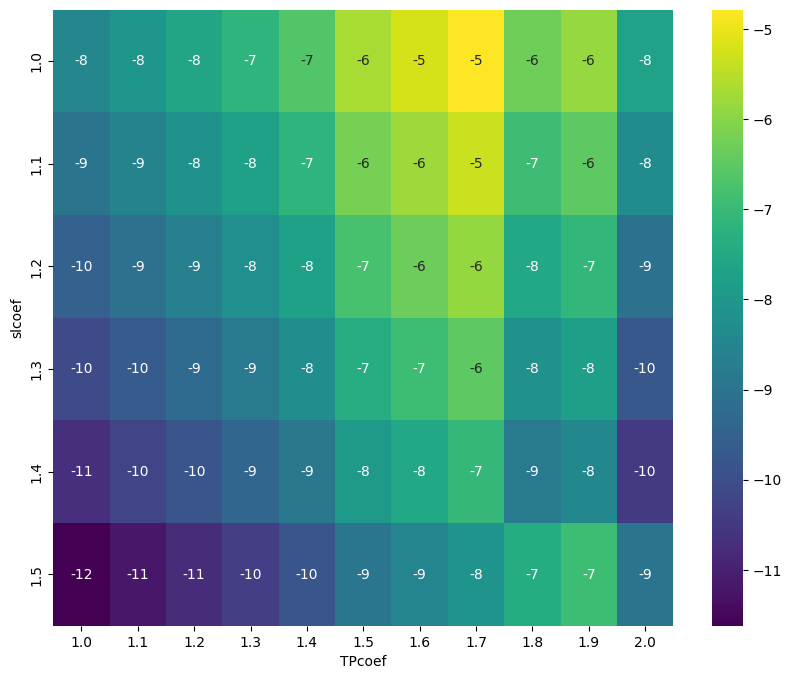

=== heatmap of GBPUSD ===


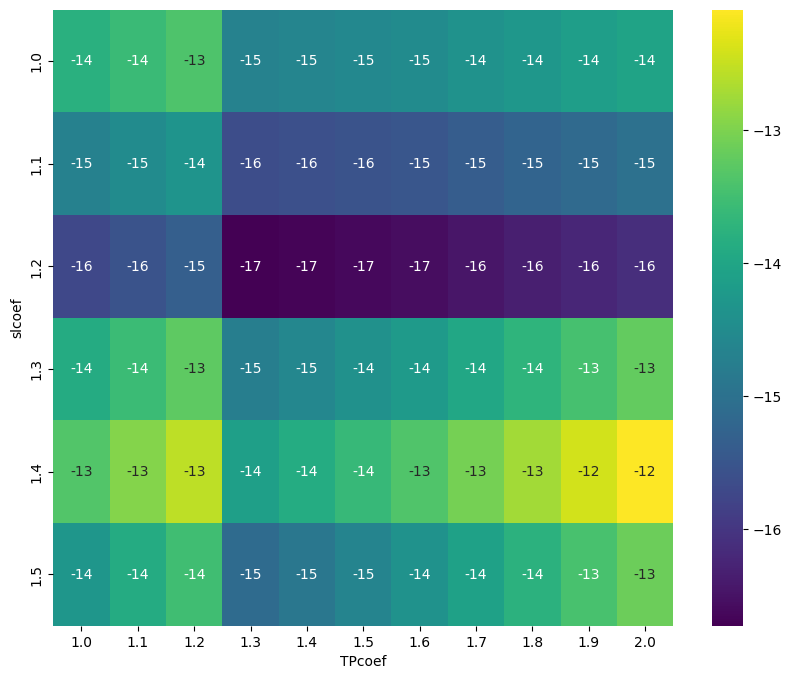

=== heatmap of USDCHF ===


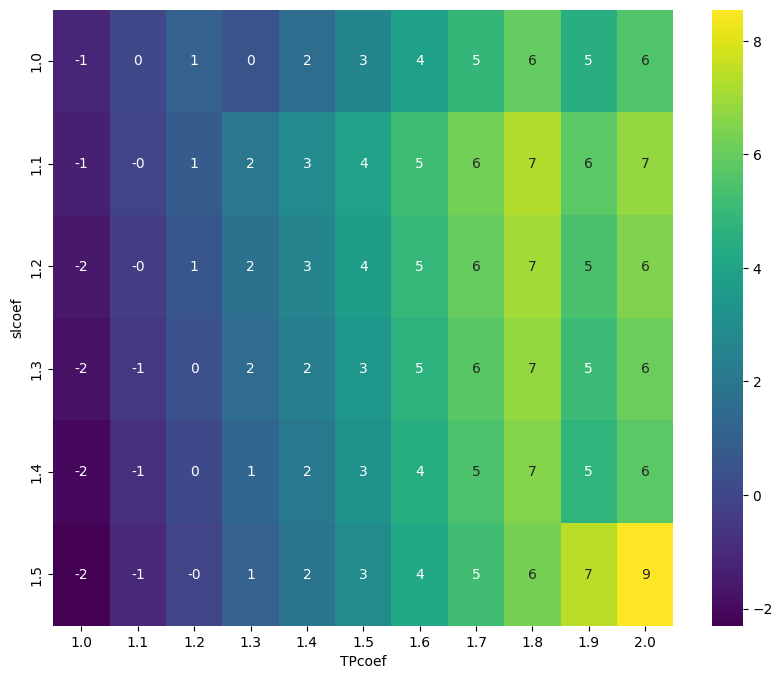

=== heatmap of USDJPY ===


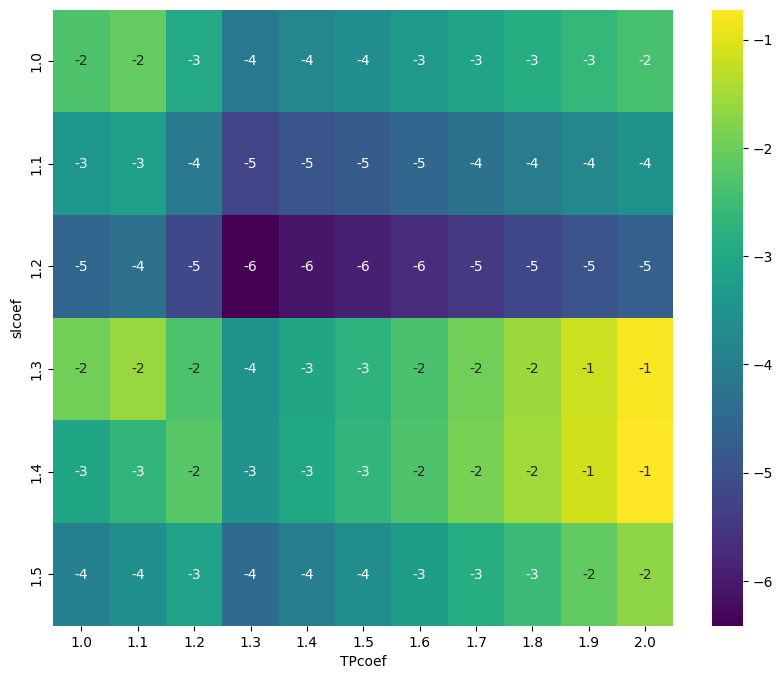

In [48]:
import seaborn as sns

for name, result_list in results.items():
    print("=== heatmap of {} ===".format(name))
    heatmap_df = result_list[1].unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
    plt.show()